# This tutorial will demonstrate automatic and manual tube segmentation and downloading/uploading data with Neuroglancer

In [19]:
import brainlit
from brainlit.utils.ngl_pipeline import NeuroglancerSession
from brainlit.viz.swc import *
from brainlit.viz.visualize import *
from brainlit.algorithms.generate_fragments import tube_seg
import napari

## Find valid segments
In this cell, we set up a NeuroglancerSession object. Since segmentation ID numbers are not in order, we print out a list of valid IDs in some range `id_range`. Most segment IDs are in `range(300)`, additionally, segments `999` and `1000` are available.

In [20]:
# Optional: Print the IDs of segments in Neuroglancer
url = "s3://mouse-light-viz/precomputed_volumes/brain1"
ngl_skel = NeuroglancerSession(url+"_segments", mip=1)
working_ids = []
id_range = 14
for seg_id in range(id_range): 
    try:
        segment = ngl_skel.cv.skeleton.get(seg_id)
        working_ids.append(seg_id)
    except:
          pass
print(working_ids)

Downloading: 1it [00:00, 18.82it/s]
Downloading: 1it [00:00, 28.87it/s]
Downloading: 1it [00:00, 25.68it/s]
Downloading: 1it [00:00, 28.92it/s]
Downloading: 1it [00:00, 26.39it/s]
Downloading: 1it [00:00, 28.66it/s]
Downloading: 1it [00:00, 29.14it/s]
Downloading: 1it [00:00, 15.27it/s]
Downloading: 1it [00:00, 30.06it/s]
Downloading: 1it [00:00, 27.47it/s]
Downloading: 1it [00:00, 27.76it/s]
Downloading: 1it [00:00, 25.52it/s]
Downloading: 1it [00:00, 17.09it/s]
Downloading: 1it [00:00, 23.89it/s]

[2, 7, 11, 12, 13]


## Download SWC information
Download the information contained in a SWC file for labelled vertices of a given `seg_id` at a valid `mip` from AWS.

In [21]:
seg_id = 13
mip = 2
df = read_s3(url+"_segments", seg_id, mip)
#df.head()
df['sample'].size # the number of vertex IDs [1, 2, ..., df['sample'].size]

Downloading: 1it [00:00, 24.20it/s]


3135

In [22]:
print(df)

      sample  structure       x       y       z    r  parent
0          1          0  1416.0  1634.0  2364.0  1.0      -1
1          2          0  1427.0  1628.0  2361.0  1.0       1
2          3         64  1441.0  1621.0  2355.0  1.0       2
3          4        192  1456.0  1612.0  2348.0  1.0       3
4          5          0  1462.0  1602.0  2343.0  1.0       4
...      ...        ...     ...     ...     ...  ...     ...
3130     273          0  1821.0  1226.0  2266.0  1.0     278
3131     268          0  1816.0  1223.0  2263.0  1.0     273
3132     249          0  1797.0  1228.0  2260.0  1.0     268
3133     236          0  1786.0  1223.0  2257.0  1.0     249
3134     234          0  1783.0  1213.0  2258.0  1.0     236

[3135 rows x 7 columns]


## Select vertices
Select a subset of the vertices in the downloaded SWC to view and segment.

In [23]:
subneuron_df = df[0:5] # choose vertices to use for the subneuron
vertex_list = subneuron_df['sample'].array 
print(vertex_list)

<PandasArray>
[1, 2, 3, 4, 5]
Length: 5, dtype: int64


## Download the Volume
Download the volume containing the specified vertices.

In [24]:
ngl = NeuroglancerSession(url, mip=mip)
buffer = [10, 10, 10]
img, bounds, vox_in_img_list = ngl.pull_vertex_list(seg_id, vertex_list, buffer = buffer, expand = True)

Downloading: 1it [00:00, 22.66it/s]
Downloading: 1it [00:00, 12.63it/s]
Downloading: 1it [00:00, 24.92it/s]
Downloading: 1it [00:00, 24.35it/s]
Downloading: 1it [00:00, 23.08it/s]
Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


## Prepare plotting functions
We add a useful plotting function to view the downloaded volume in Napari.

In [25]:
def napari_viewer(img, labels=None, shapes=None, label_name="Segmentation"):
    viewer = napari.view_image(np.squeeze(np.array(img)))
    if labels is not None:
        viewer.add_labels(labels, name=label_name)
    if shapes is not None:
        viewer.add_shapes(data=shapes, shape_type='path', edge_color='blue', name='Skeleton')
    return viewer

Let's take a look at the downloaded volume. Napari will open in a new window.

In [26]:
%gui qt

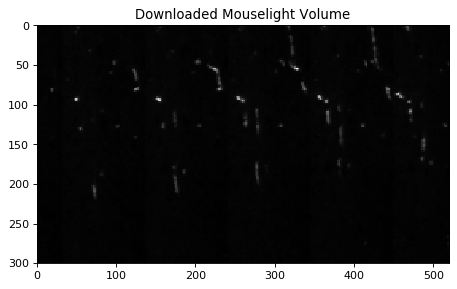

In [27]:
plot_3d(sitk.GetImageFromArray(np.squeeze(img), isVector=False), zslices=range(48,53), title = "Downloaded Mouselight Volume")
n=napari_viewer(img)

We get a `corrected_subneuron_df` that contains `(x,y,z)` coordinates within the downloaded volume for the vertices in the SWC.

In [28]:
corrected_subneuron_df = generate_df_subset(subneuron_df, vox_in_img_list)
print(corrected_subneuron_df)

   sample  structure   x    y   z    r  parent
0       1          0  55   46  34  1.0      -1
1       2          0  50   60  35  1.0       1
2       3         64  54   81  35  1.0       2
3       4        192  50   91  34  1.0       3
4       5          0  47  111  36  1.0       4


Convert the SWC to a graph and print some information about the graph.

In [29]:
G = df_to_graph(corrected_subneuron_df)
print('Number of nodes:', len(G.nodes))
print('Number of edges:', len(G.edges))
print('Sample 1 coordinates (x,y,z):', G.nodes[1])
paths = graph_to_paths(G)
print('Number of paths:', len(paths))

Number of nodes: 5
Number of edges: 4
Sample 1 coordinates (x,y,z): {'x': 55, 'y': 46, 'z': 34}
Number of paths: 1


We can display the SWC on the Volume

In [30]:
%gui qt
napari_viewer(img, shapes=paths)

## Automatically segment the neuron

We compute a tube segmentation.

In [34]:
labels = tube_seg.tubes_seg(img, vox_in_img_list, 2)

We can display the volume, SWC, and segmentation in Napari.

In [35]:
%gui qt
viewer = napari_viewer(img, labels=labels, shapes=paths, label_name="Tube Segmentation")

## Steps to Manually Edit Labels
Labels can be manually edited following these steps:

1. Ensure Napari is in 2D-slice viewing, not 3D view. (The second button from the bottom left)
2. Click the image layer and adjust the contrast limits as desired.
3. Click the "Confidence-Connected Threshold Layer"
4. Click the paintbrush tool and adjust the brush size. Ensure that "label" is set to 1 to paint and 0 to erase.
5. Click and drag on the image to adjust labels. Changes are saved automatically, and CMD-Z to undo is supported.

Extract the manual labels for uploading.

In [36]:
manual_labels = viewer.layers["Tube Segmentation"].data

Upload the segmentation to AWS.

In [37]:
%%capture
ngl_upload = NeuroglancerSession(url+"_seg", mip=mip)
ngl_upload.push(manual_labels, bounds);

Confirm that the upload was successful. It was!

In [38]:
downloaded_labels = ngl_upload.pull_bounds_seg(bounds)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


In [39]:
print(np.all(manual_labels == downloaded_labels))

True
